In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# Compare Sets Appyter
#### This appyter creates a Venn diagram to visualize the intersections between 2-6 user-inputted gene sets. The user has a choice whether to uplaod a tsv file with the desired genes or to insert the genes into text boxes. 

In [2]:
# Imports
## Venn Diagram
from venn import venn, pseudovenn

## Data Processing
import csv

## Link to Enrichr
import requests
import json
import time
from IPython.display import display, FileLink, Markdown

## Fisher Exact Test
from tabulate import tabulate
import scipy.stats as stats

## UpSet Plot
from upsetplot import from_contents, plot
from matplotlib import pyplot

%matplotlib inline

In [3]:
%%appyter hide_code
{% do SectionField(name='section0', title='Compare Gene Sets', subtitle='Create a venn diagram to compare your inputted gene sets', img = 'spiral.png') %}
{% do SectionField(name='section1', title='1. Submit Your Gene Lists', subtitle = 'Upload text files containing your gene list -OR- copy and paste your gene list into each text box below (One gene per row). Default genes are provided below, but you can submit your own gene sets and delete the default data if you wish to do so.', img = 'bulb.png') %}
{% do SectionField(name='section2', title='2. Venn Diagram', subtitle = 'Generate a Venn Diagram from 2-6 inputted sets.', img = 'venndiagram.png') %}
{% do SectionField(name='section3', title='3. UpSet Plot', subtitle = 'Generate an UpSet plot from the inputted sets. This can be useful if you have many sets to compare.', img = 'gears.png') %}
{% do SectionField(name='section4', title='4. Fisher Exact Test (Optional)', subtitle = 'Choose two gene lists to see if their overlap is significant.', img = 'brain.png') %}


## Input Gene Lists

In [6]:
%%appyter code_exec

gs1 = {{ FileField(name = 'gs1', label = 'Gene Set 1 File', default = '', section = 'section1') }}
gs2 = {{ FileField(name = 'gs2', label = 'Gene Set 2 File', default = '', section = 'section1') }}
gs3 = {{ FileField(name = 'gs3', label = 'Gene Set 3 File', default = '', section = 'section1') }}
gs4 = {{ FileField(name = 'gs4', label = 'Gene Set 4 File', default = '', section = 'section1') }}
gs5 = {{ FileField(name = 'gs5', label = 'Gene Set 5 File', default = '', section = 'section1') }}
gs6 = {{ FileField(name = 'gs6', label = 'Gene Set 6 File', default = '', section = 'section1') }}


gs1Text = {{ TextField(name = 'gs1Text', label = 'Gene Set 1', default = '''TRPV1
OPRM1
TRPA1
COMT
SCN9A
TNF
IL6
IL1B
CRP
BDNF
NGF
SLC6A4
MEFV
TRPM8
TRPV4
CALCA
NTRK1
TLR4
ASIC3
SCN10A
MMP9
CNR1
IL10
CCL2
TNNT2
NPPB
PTGS2
CYP2D6
P2RX3
TACR1''', section = 'section1') }}
gs2Text = {{ TextField(name = 'gs2Text', label = 'Gene Set 2', default = '''TNF
TRPV1
CRP
FOS
PTGS2
NGF
TRPA1
BDNF
CD34
POMC
IVD
IL10
ACE
CASP3
CCL2
TLR4
GFAP
TRPM8
IL6
CD68
KIT
OPRM1
SCN9A
CYP2D6
COMT
CEACAM5
GDNF
NPY
PTH
TRPV4''', section = 'section1') }}
gs3Text = {{ TextField(name = 'gs3Text', label = 'Gene Set 3', default = '''OPRD1
TRPV1
TRPA1
SCN9A
OPRM1
TRPM8
TACR1
OPRK1
TAC1
SCN3B
KCNS1
TRPV3
TRPV4
CACNA1B
CACNA2D2
SCN11A
NTRK1
PENK
SCN1B
OPRL1
PDYN
TRPV2
HTR3C
HTR3A
COMT
P2RX3
TRPM5
DRD2
NGFR
FAAH
ASIC3
PNOC
HTR3B
TRPM4
CACNA2D3
BDKRB1
ASIC4
HTR2A
KCNC2
CHRM4
TRPM3
HTR3E
CACNG2
CHRNA7
SCN10A''', section = 'section1') }}
gs4Text = {{ TextField(name = 'gs4Text', label = 'Gene Set 4', default = '', section = 'section1') }}
gs5Text = {{ TextField(name = 'gs5Text', label = 'Gene Set 5', default = '', section = 'section1') }}
gs6Text = {{ TextField(name = 'gs6Text', label = 'Gene Set 6', default = '', section = 'section1') }}

venndiagram = {{ BoolField(name = 'venndiagram', label = 'Venn Diagram?', default = 'true', description = 'Select \'Yes\' if you would like to generate a Venn diagram. Otherwise, select \'No\'', section = 'section2') }}

scheme = "{{ ChoiceField(name = 'scheme', label = 'Color Scheme', choices = ['viridis', 'cool', 'plasma', 'inferno', 'magma'], default = 'viridis', description = 'Choose a color scheme for your Venn diagram', section = 'section2') }}"

venn_file_format = {{ MultiCheckboxField(name = 'venn_file_format', label = 'File Format', choices = ['png', 'jpg', 'svg'], default = ['png'], description = 'Select the format(s) to save your Venn diagram', section = 'section2') }}

venn_file_name = {{ StringField(name = 'venn_file_name', label = 'File Name', default = 'venn', description = 'Enter a name/description to save your Venn diagram', section = 'section2') }}

upset = {{ BoolField(name = 'upset', label = 'UpSet Plot?', default = 'true', description = 'Select \'Yes\' if you would like to generate an UpSet plot. Otherwise, select \'No\'', section = 'section3') }}

orient = "{{ ChoiceField(name = 'orient', label = 'Orientation', choices = ['Horizontal', 'Vertical'], default = 'Horizontal', description = 'Choose whether your UpSet plot will be displayed horizontally or vertically', section = 'section3') }}"

color = "{{ ChoiceField(name = 'color', label = 'Color', choices = ['Black', 'Blue', 'Red', 'Green', 'Grey', 'Orange', 'Purple', 'Yellow', 'Pink'], default = 'black', section = 'section3') }}"

counts = {{ BoolField(name = 'counts', label = 'Show Counts?', default = 'true', description = 'This labels the intersection size bars with the cardinality of the intersection.', section = 'section3') }}

percent = {{ BoolField(name = 'percent', label = 'Show Percentages?', default = 'false', description = 'This labels the intersection size bars with the percentage of the intersection relative to the total dataset.', section = 'section3') }}

figure_file_format = {{ MultiCheckboxField(name = 'figure_file_format', label = 'File Format', choices = ['png', 'jpg', 'svg'], default = ['png'], description = 'Select the format to save your figure', section = 'section3') }}

output_file_name = {{ StringField(name = 'output_file_name', label = 'File Name', default = 'UpSet_plot', description = 'Enter a name/description to save your UpSet Plot', section = 'section3') }}

fisher = {{ BoolField(name = 'fisher', label = 'Fisher Exact Test?', default = 'false', description = 'Select \'Yes\' if you would like to perform the Fisher Exact Test. Otherwise, select \'No\'', section = 'section4') }}

gs_A = {{ ChoiceField(name = 'gs_A', label = 'Gene Set A', choices = {'Gene Set 1': '1', 'Gene Set 2': '2', 'Gene Set 3': '3', 'Gene Set 4': '4', 'Gene Set 5': '5', 'Gene Set 6': '6'}, default = 'Gene Set 1', section = 'section4') }}

gs_B = {{ ChoiceField(name = 'gs_B', label = 'Gene Set B', choices = {'Gene Set 1': '1', 'Gene Set 2': '2', 'Gene Set 3': '3', 'Gene Set 4': '4', 'Gene Set 5': '5', 'Gene Set 6': '6'}, default = 'Gene Set 2', section = 'section4') }}

background = {{ IntField(name = 'background', label = 'Background', default = 20000, description = 'Human genes typically have a background of 20,000', section = 'section4') }}

significance = {{ ChoiceField(name = 'significance', label = 'Significance Level', choices = {'0.01': '0.01', '0.05': '0.05', '0.10': '0.10'}, default = '0.05', description = 'Choose a significance level', section = 'section4')}}

final_venn_file_names = [str(venn_file_name + '.' + file_type) for file_type in venn_file_format]

final_output_file_names = [str(output_file_name + '.' + file_type) for file_type in figure_file_format]

In [ ]:
#Color for UpSet plot
color_conversion = {
    'Black': 'black',
    'Blue': 'lightskyblue',
    'Red': 'tomato',
    'Green': 'mediumspringgreen',
    'Grey': 'lightgrey',
    'Orange': 'orange',
    'Purple': 'plum',
    'Yellow': 'yellow',
    'Pink': 'lightpink'
}

color = color_conversion[color]

## Convert Inputs into Lists

In [19]:
%%appyter code_exec
# Helper functions to conver the file upload or text input into gene lists
def file_to_list(str):
    l1 = []
    tsv_file = open(str)
    read_tsv = csv.reader(tsv_file, delimiter = '\t')

    for row in read_tsv:
        l1.append(row[0])

    tsv_file.close()
    return l1

def text_to_list(str):
    l1 = str.splitlines()
    return l1


```python
# Helper functions to conver the file upload or text input into gene lists
def file_to_list(str):
    l1 = []
    tsv_file = open(str)
    read_tsv = csv.reader(tsv_file, delimiter = '\t')
    for row in read_tsv:
        l1.append(row[0])
    tsv_file.close()
    return l1
def text_to_list(str):
    l1 = str.splitlines()
    return l1
```

In [20]:
# Add the appropriate gene lists to the dictionary

gsdict = {}

if gs1 != '':
    l1 = file_to_list(gs1)
    gsdict["Gene Set 1"] = set(l1)

elif gs1Text != '''''':
    l1 = text_to_list(gs1Text)
    gsdict["Gene Set 1"] = set(l1)

if gs2 != '':
    l2 = file_to_list(gs2)
    gsdict["Gene Set 2"] = set(l2)

elif gs2Text != '''''':
    l2 = text_to_list(gs2Text)
    gsdict["Gene Set 2"] = set(l2)

if gs3 != '':
    l3 = file_to_list(gs3)
    gsdict["Gene Set 3"] = set(l3)

elif gs3Text != '''''':
    l3 = text_to_list(gs3Text)
    gsdict["Gene Set 3"] = set(l3)

if gs4 != '':
    l4 = file_to_list(gs4)
    gsdict["Gene Set 4"] = set(l4)

elif gs4Text != '''''':
    l4 = text_to_list(gs4Text)
    gsdict["Gene Set 4"] = set(l4)

if gs5 != '':
    l5 = file_to_list(gs5)
    gsdict["Gene Set 5"] = set(l5)

elif gs5Text != '''''':
    l5 = text_to_list(gs5Text)
    gsdict["Gene Set 5"] = set(l5)

if gs6 != '':
    l6 = file_to_list(gs6)
    gsdict["Gene Set 6"] = set(l6)

elif gs6Text != '''''':
    l6 = text_to_list(gs6Text)
    gsdict["Gene set 6"] = set(l6)


## Draw Venn Diagram

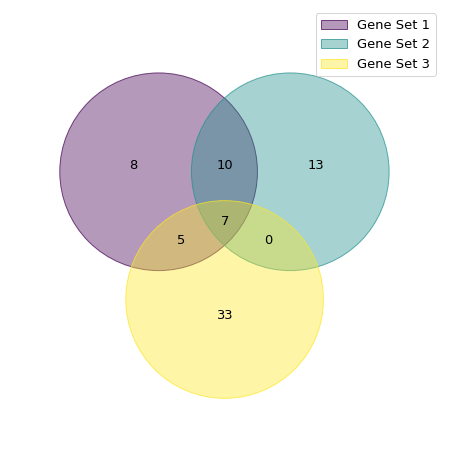

In [21]:
# Generate the venn diagram
if venndiagram:
    venn(gsdict, cmap = scheme)

    for plot_name in final_venn_file_names:
        pyplot.savefig(plot_name, bbox_inches = 'tight')
    pyplot.show()
    

    if len(gsdict) == 6:
        pseudovenn(gsdict)

In [ ]:
# Download Venn Diagrams
for i, file in enumerate(final_venn_file_names):
    display(FileLink(file, result_html_prefix=str('Download ' + venn_file_format[i] + ': ')))

## Draw UpSet Plot

In [ ]:
# UpSet Plots
if upset:
    df = from_contents(gsdict)
    plot(df, orientation = orient.lower(), facecolor = color, show_counts = counts, show_percentages = percent)
    for plot_name in final_output_file_names:
        pyplot.savefig(plot_name, bbox_inches = 'tight')
    pyplot.show()
    

In [ ]:
# Download UpSet Plots
for i, file in enumerate(final_output_file_names):
    display(FileLink(file, result_html_prefix = str('Download ' + figure_file_format[i] + ': ')))

## Compute Fisher's Exact Test

In [ ]:
# Fisher Exact Test
if fisher:
    s1 = set(l1)
    s2 = set(l2)

    if gs_A == 2:
        s1 = set(l2)
    elif gs_A == 3:
        s1 = set(l3)
    elif gs_A == 4:
        s1 = set(l4)
    elif gs_A == 5:
        s1 = set(l5)
    elif gs_A == 6:
        s1 = set(l6)

    if gs_B == 1:
        s2 = set(l1)
    elif gs_B == 3:
        s2 = set(l3)
    elif gs_B == 4:
        s2 = set(l4)
    elif gs_B == 5:
        s2 = set(l5)
    elif gs_B == 6:
        s2 = set(l6)
    
    inter = len(s1 & s2)
    not_A_not_B = background - (len(s1) + len(s2) - inter)
    in_A_not_B = len(s1) - inter
    not_A_in_B = len(s2) - inter
    total = not_A_not_B + not_A_in_B + in_A_not_B + inter

    print('You are examining the overlap between Gene Set ' + str(gs_A) + ' and Gene Set ' + str(gs_B) + ':\n')
    
    print(tabulate([['Not in B', not_A_not_B, in_A_not_B, not_A_not_B+in_A_not_B], ['In B', not_A_in_B, inter, not_A_in_B+inter], ['Marginal Column Totals', not_A_not_B+not_A_in_B, in_A_not_B+inter, str(total) + ' (Grand Total)']], headers = ['', 'Not in A', 'In A', 'Marginal Row Totals'] ))

    oddsratio, pvalue = stats.fisher_exact([[not_A_not_B, in_A_not_B], [not_A_in_B, inter]])
    print('\np-value: ' + str(pvalue))
    print('Odds Ratio: ' + str(oddsratio))
    if pvalue < significance:
        print('This result is significant at p < ' + str(significance))
    else:
        print('This result is not significant at p < ' + str(significance))